In [1]:
import numpy as np
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group
import pandas as pd
import jax.numpy as jnp
from jax import grad, vmap

dim_in = 5
active = 2
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 5000
#rotation = pickle.load(open("rotation.pk", "rb"))
rotation = special_ortho_group.rvs(dim_in)
#print(rotation)
x_train = np.random.rand(n,dim_in)*2 - 1
y_train = simulate_y(x_train, rotation)

x_test = np.random.rand(1000,dim_in)*2 - 1
y_test = simulate_y(x_test, rotation)

sample_range = [500, 1000, 2000, 5000]

In [2]:
M = 10                      # number of Mondrian trees to use
delta = 0.1              # ridge regression delta

In [3]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_train, rotation)
from numpy import linalg
from src.Mondrian_matrix_utils import two_one_norm
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n
true_H = true_H / two_one_norm(true_H)

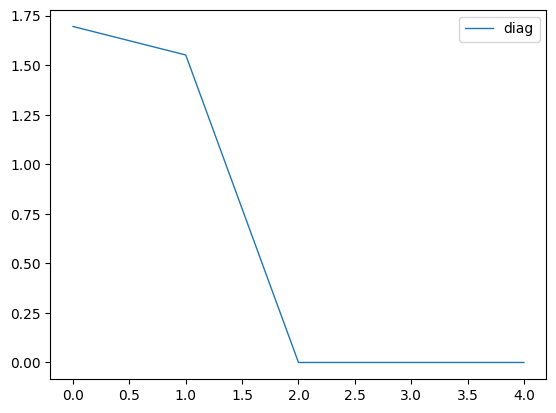

In [4]:
eigenvalues, eigenvectors = linalg.eig(true_H)
from src.Mondrian_matrix_utils import draw
draw(dim_in, eigenvalues)

In [5]:
def get_angle_distance(H, truth):
    dim_proj = active
    proj = np.identity(dim_proj)
    proj = np.pad(proj, [(0, dim_in - dim_proj), (0, dim_in - dim_proj)], mode='constant')
    
    _, eigenvectors = linalg.eig(H)
    Q_H, _ = linalg.qr(eigenvectors[:, :active])
    
    Q_t, _ = linalg.qr(truth[:, :active])

    D = np.matmul(np.transpose(Q_H), Q_t)
    U, S, Vh = np.linalg.svd(D, full_matrices=True)
    return np.arccos(S)

In [6]:
from src.Mondrian_matrix_utils import train, evaluate, two_one_norm, populate_importance
from sklearn.metrics import mean_squared_error

def train_and_evaluate(x_train, y_train, x_test, y_test, M, lifetime_max, delta):

    X_bd_all, X, history, w_kernel, y_hat_train = train(x_train, y_train, M, lifetime_max, delta, mondrian_kernel = True,
                                    )
    _, y_hat_test = evaluate(x_train, y_train, x_test, M, delta, history, w_kernel, mondrian_kernel = True, 
                                    )

    mse = mean_squared_error(y_test, y_hat_test)
    return mse, X_bd_all, X, history, w_kernel, y_hat_train

def estimate_H(x_train, y_train, X_bd_all, M, delta, X, history, w_kernel, y_hat_train):
    dim_in = X.shape[1]
    n = X.shape[0]
    importance = []
    for dim in range(dim_in):
        try:
            x_eval = None
            y_eval = []
            x_diff = []
            subset_all = []
            for tree in range(M):
                temp = X_bd_all[tree,dim] - X
                subset = temp[:,dim] != 0
                subset_all = subset_all + list(subset)
                
                if sum(subset) > 0:
                    if x_eval is None:
                        x_eval = X_bd_all[tree,dim][subset]
                    else:
                        x_eval = np.vstack((x_eval, X_bd_all[tree,dim][subset]))
                    y_eval = y_eval + y_hat_train[subset].tolist()
                    x_diff = x_diff + list(temp[:,dim][subset])
            
            _, y_hat_eval = evaluate(x_train, y_train, x_eval, M, delta, history, w_kernel, mondrian_kernel = True)
            y_eval = np.array(y_eval)
            x_diff = np.array(x_diff)
            importance_temp = populate_importance(subset_all, ((y_eval - y_hat_eval)/x_diff))
            importance_temp = np.reshape(importance_temp, (len(X), M))
            importance_temp = np.median(importance_temp, axis = 1)
        except:
            importance_temp = np.zeros(len(X))
        importance.append(importance_temp)
    importance = np.vstack(importance)

    H = np.matmul(importance, np.transpose(importance))

    #eig = np.linalg.eig(H)[0]
    #y_diag = np.diagonal(H)
    #plot_spectrum(eig, y_diag, 'spectrum')
    return H

def transform_data(H, x_train, x_test):
    x_train_transformed = np.matmul(x_train, H)
    x_test_transformed = np.matmul(x_test, H)
    return x_train_transformed, x_test_transformed

In [7]:
from tqdm import tqdm

def plot_trend(stats, xlabel, ylabel, title):
    df = pd.DataFrame(stats)

    # Prepare the data for plotting
    plot_data = [df[ylabel][i] for i in range(len(df))]

    # Create the boxplot
    plt.boxplot(plot_data, labels=[str(x[xlabel]) for x in stats])

    # Add titles and labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Show the plot
    plt.show()

100%|██████████| 4/4 [01:53<00:00, 28.30s/it]


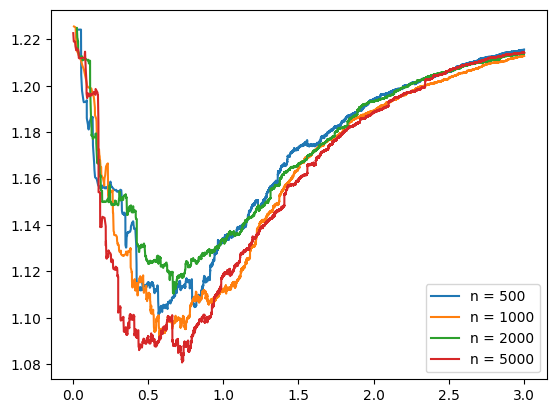

In [8]:
from src.Mondrian_kernel import evaluate_all_lifetimes
lifetime_max = 3
for n_sim in tqdm(sample_range):
    results = evaluate_all_lifetimes(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta)
    print("min mse: " + str(min(results['mse'])))
    print("time: " + str(results['times'][np.where(results['mse'] == min(results['mse']))[0][0]]))
    plt.plot(results['times'], results['mse'], label = 'n = ' + str(n_sim))
    plt.legend()

In [9]:
def experiment(x_train, y_train, x_test, y_test, M, lifetime_max, delta, H, full = True):
    mse, X_bd_all, X, history, w_kernel, y_hat_train = train_and_evaluate(x_train, y_train, x_test, y_test, M, lifetime_max, delta)
    H_itr = estimate_H(x_train, y_train, X_bd_all, M, delta, X, history, w_kernel, y_hat_train)
    if full:
        H = np.matmul(np.matmul(H, H_itr), H)
    else:
        H = np.matmul(H, H_itr)
    if two_one_norm(H) == 0:
        return mse, H
    H = H / two_one_norm(H)
    return mse, H

100%|██████████| 5/5 [00:31<00:00,  6.31s/it]


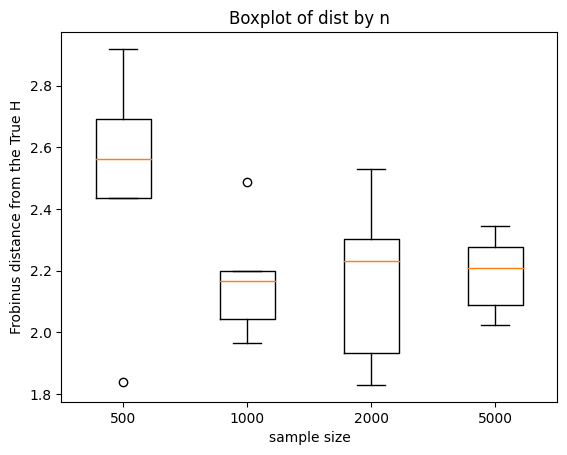

In [11]:
lifetime_max = 0.6

stats = []
for n_sim in sample_range:
    dist = {'n': n_sim, 'dist': [], 'H': []}
    for trial in tqdm(range(5)):
        lifetime = lifetime_max * ((n_sim / sample_range[0]) ** (1/5))
        mse, X_bd_all, X, history, w_kernel, y_hat_train = train_and_evaluate(
            x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta)
        H_0 = estimate_H(x_train[:n_sim, ], y_train[:n_sim], X_bd_all, M, delta, X, history, w_kernel, y_hat_train)
        H_0 = H_0 / two_one_norm(H_0)
        dist['dist'].append((linalg.norm(H_0 - true_H, ord = 'fro')))
        dist['H'].append(H_0)
    stats.append(dist)

df = pd.DataFrame(stats)

# Prepare the data for plotting
plot_data = [df['dist'][i] for i in range(len(df))]

# Create the boxplot
plt.boxplot(plot_data, labels=[str(x['n']) for x in stats])

# Add titles and labels
plt.title('Boxplot of dist by n')
plt.xlabel('sample size')
plt.ylabel('Frobinus distance from the True H')

# Show the plot
plt.show()